In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sn
from xgboost.sklearn import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, MaxPooling1D, Conv1D, AlphaDropout


import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [91]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

In [92]:
dataset = pd.read_csv('epileptic_seizure_recognition.csv')

In [93]:
df = dataset[dataset.y != 4]
df = df[df.y != 3]
df = df[df.y != 2]

In [104]:
tgt = df.y
tgt = tgt.replace([1,5],[0,1])

X = df.iloc[:,1:179].values
y = tgt.iloc[:].values

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [100]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                           min_delta=0,
                                           patience=10000,
                                           verbose=1,
                                           mode='auto')
from keras.callbacks import ModelCheckpoint
filepath="weights_ZvsS_sgd_simples.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Initialising the ANN
clf_ann = Sequential()

# Adding the input layer and the first hidden layer
clf_ann.add(Dense(activation="relu", 
                  units=178,
                  input_dim=178,
                  kernel_initializer='he_normal'))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the second hidden layer
clf_ann.add(Dense(activation="relu",
                  units=178,
                  kernel_initializer='he_normal'))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the output layer
clf_ann.add(Dense(units=1,
                  kernel_initializer='glorot_normal',
                  activation="sigmoid"))

# Compiling the ANN
clf_ann.compile(optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
# loss = 'categorical_crossentropy'
# Fitting the ANN to the Training set
clf_ann.fit(X_train, y_train,
               batch_size = 256,
               epochs = 200,
               validation_data=(X_test,y_test),
               callbacks=[early_stop, checkpoint])

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = clf_ann.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
#cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Seizure', 'Healthy']))

#df_cm = pd.DataFrame(cm, range(3), range(3))
#sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

Train on 3680 samples, validate on 920 samples
Epoch 1/200
3680/3680 [==============================] - 4s 1ms/step - loss: 0.4414 - acc: 0.7943 - val_loss: 0.3704 - val_acc: 0.8174

Epoch 00001: val_acc improved from -inf to 0.81739, saving model to weights_ZvsS_sgd_simples.best.h5
Epoch 2/200
3680/3680 [==============================] - 0s 107us/step - loss: 0.2499 - acc: 0.8853 - val_loss: 0.2513 - val_acc: 0.8761

Epoch 00002: val_acc improved from 0.81739 to 0.87609, saving model to weights_ZvsS_sgd_simples.best.h5
Epoch 3/200
3680/3680 [==============================] - 0s 109us/step - loss: 0.1891 - acc: 0.9122 - val_loss: 0.1541 - val_acc: 0.9250

Epoch 00003: val_acc improved from 0.87609 to 0.92500, saving model to weights_ZvsS_sgd_simples.best.h5
Epoch 4/200
3680/3680 [==============================] - 0s 101us/step - loss: 0.1374 - acc: 0.9489 - val_loss: 0.1068 - val_acc: 0.9522

Epoch 00004: val_acc improved from 0.92500 to 0.95217, saving model to weights_ZvsS_sgd_simple

3680/3680 [==============================] - 0s 120us/step - loss: 0.0234 - acc: 0.9946 - val_loss: 0.0119 - val_acc: 0.9978

Epoch 00039: val_acc did not improve
Epoch 40/200
3680/3680 [==============================] - 0s 107us/step - loss: 0.0214 - acc: 0.9932 - val_loss: 0.0113 - val_acc: 0.9978

Epoch 00040: val_acc did not improve
Epoch 41/200
3680/3680 [==============================] - 1s 168us/step - loss: 0.0249 - acc: 0.9905 - val_loss: 0.0111 - val_acc: 0.9967

Epoch 00041: val_acc did not improve
Epoch 42/200
3680/3680 [==============================] - 1s 147us/step - loss: 0.0247 - acc: 0.9921 - val_loss: 0.0106 - val_acc: 0.9978

Epoch 00042: val_acc did not improve
Epoch 43/200
3680/3680 [==============================] - 1s 153us/step - loss: 0.0224 - acc: 0.9921 - val_loss: 0.0107 - val_acc: 0.9978

Epoch 00043: val_acc did not improve
Epoch 44/200
3680/3680 [==============================] - 0s 102us/step - loss: 0.0221 - acc: 0.9932 - val_loss: 0.0106 - val_acc: 0.

3680/3680 [==============================] - 0s 125us/step - loss: 0.0154 - acc: 0.9951 - val_loss: 0.0055 - val_acc: 0.9989

Epoch 00085: val_acc did not improve
Epoch 86/200
3680/3680 [==============================] - 0s 103us/step - loss: 0.0109 - acc: 0.9967 - val_loss: 0.0054 - val_acc: 0.9989

Epoch 00086: val_acc did not improve
Epoch 87/200
3680/3680 [==============================] - 0s 120us/step - loss: 0.0141 - acc: 0.9957 - val_loss: 0.0054 - val_acc: 0.9989

Epoch 00087: val_acc did not improve
Epoch 88/200
3680/3680 [==============================] - 0s 130us/step - loss: 0.0113 - acc: 0.9962 - val_loss: 0.0055 - val_acc: 0.9989

Epoch 00088: val_acc did not improve
Epoch 89/200
3680/3680 [==============================] - 0s 115us/step - loss: 0.0152 - acc: 0.9943 - val_loss: 0.0056 - val_acc: 0.9989

Epoch 00089: val_acc did not improve
Epoch 90/200
3680/3680 [==============================] - 1s 149us/step - loss: 0.0136 - acc: 0.9965 - val_loss: 0.0055 - val_acc: 0.


Epoch 00131: val_acc did not improve
Epoch 132/200
3680/3680 [==============================] - 0s 80us/step - loss: 0.0085 - acc: 0.9965 - val_loss: 0.0047 - val_acc: 0.9989

Epoch 00132: val_acc did not improve
Epoch 133/200
3680/3680 [==============================] - 0s 80us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0048 - val_acc: 0.9989

Epoch 00133: val_acc did not improve
Epoch 134/200
3680/3680 [==============================] - 0s 70us/step - loss: 0.0087 - acc: 0.9984 - val_loss: 0.0047 - val_acc: 0.9989

Epoch 00134: val_acc did not improve
Epoch 135/200
3680/3680 [==============================] - 0s 70us/step - loss: 0.0091 - acc: 0.9973 - val_loss: 0.0046 - val_acc: 0.9989

Epoch 00135: val_acc did not improve
Epoch 136/200
3680/3680 [==============================] - 0s 72us/step - loss: 0.0098 - acc: 0.9970 - val_loss: 0.0045 - val_acc: 0.9989

Epoch 00136: val_acc did not improve
Epoch 137/200
3680/3680 [==============================] - 0s 73us/step - loss: 0.

3680/3680 [==============================] - 0s 89us/step - loss: 0.0087 - acc: 0.9973 - val_loss: 0.0043 - val_acc: 0.9978

Epoch 00178: val_acc did not improve
Epoch 179/200
3680/3680 [==============================] - 0s 115us/step - loss: 0.0081 - acc: 0.9981 - val_loss: 0.0046 - val_acc: 0.9978

Epoch 00179: val_acc did not improve
Epoch 180/200
3680/3680 [==============================] - 0s 87us/step - loss: 0.0054 - acc: 0.9981 - val_loss: 0.0048 - val_acc: 0.9978

Epoch 00180: val_acc did not improve
Epoch 181/200
3680/3680 [==============================] - 0s 129us/step - loss: 0.0080 - acc: 0.9978 - val_loss: 0.0049 - val_acc: 0.9978

Epoch 00181: val_acc did not improve
Epoch 182/200
3680/3680 [==============================] - 0s 69us/step - loss: 0.0077 - acc: 0.9970 - val_loss: 0.0049 - val_acc: 0.9978

Epoch 00182: val_acc did not improve
Epoch 183/200
3680/3680 [==============================] - 0s 123us/step - loss: 0.0093 - acc: 0.9967 - val_loss: 0.0046 - val_acc: 

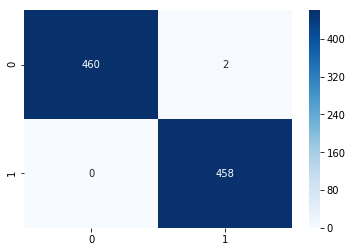

In [101]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

In [102]:
sgdr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle')
from keras.callbacks import ModelCheckpoint
filepath="weights_ZvsS_sgd_tests.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

clf_ann.compile(optimizer=keras.optimizers.SGD(decay=1e-4, momentum=0.9),
                loss='binary_crossentropy',
                metrics=['accuracy'])
clf_ann.fit(X_train, y_train,
            batch_size = 256,
            epochs = 10,
            validation_data=(X_test,y_test),
            callbacks=[sgdr,checkpoint])
# Predicting the Test set results
y_pred = clf_ann.predict(X_test)
y_pred = (y_pred > 0.5)
print(classification_report(y_test, y_pred, target_names=['Seizure', 'Healthy']))

Train on 3680 samples, validate on 920 samples
Epoch 1/10
3680/3680 [==============================] - 2s 439us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0044 - val_acc: 0.9978

Epoch 00001: val_acc improved from -inf to 0.99783, saving model to weights_ZvsS_sgd_tests.best.h5
Epoch 2/10
3680/3680 [==============================] - 0s 111us/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0044 - val_acc: 0.9978

Epoch 00002: val_acc did not improve
Epoch 3/10
3680/3680 [==============================] - 0s 108us/step - loss: 0.0070 - acc: 0.9984 - val_loss: 0.0043 - val_acc: 0.9978

Epoch 00003: val_acc did not improve
Epoch 4/10
3680/3680 [==============================] - 1s 138us/step - loss: 0.0064 - acc: 0.9984 - val_loss: 0.0043 - val_acc: 0.9989

Epoch 00004: val_acc improved from 0.99783 to 0.99891, saving model to weights_ZvsS_sgd_tests.best.h5
Epoch 5/10
3680/3680 [==============================] - 0s 134us/step - loss: 0.0051 - acc: 0.9992 - val_loss: 0.0043 - val_acc: 0

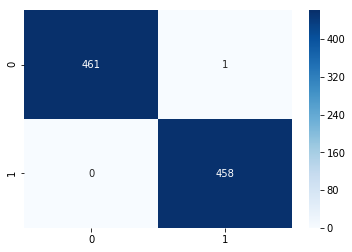

In [103]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size